## Imports

In [319]:
# General Image Imports
import os
import re
import glob
import requests
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from PIL import Image

# Torch vision and utils
import torch
from torch import nn
import torchvision
from pathlib import Path
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Resize, Normalize, Compose

# Model
import torchvision.models as models



## Confusion Matrix Functions

In [351]:
def buildConfusionMatrix(y_pred, y_true, classes):
  cf_matrix = confusion_matrix(y_true, y_pred, classes)
  df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
  plt.figure(figsize = (8,7))
  sn.heatmap(df_cm, annot=True, cmap="Blues", fmt="d")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")

In [375]:
def getMetrics(true, pred):
  df = pd.DataFrame(classification_report(true, pred, output_dict=True)).T
  ovp = np.mean(df.loc[:,"precision"])
  ovr = np.mean(df.loc[:,"recall"])
  ova = np.mean(df.loc["accuracy",:])
  ovf = np.mean(df.loc[:,"f1-score"])
  print(f"Overall Accuracy: {ova}, Precision: {ovp}, Recall: {ovr}, F1-Score: {ovf}")
  return (ova, ovp, ovr, ovf)

## Helper Functions

In [352]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [353]:
def storeImagePairs(img_dir):
    dirpath = img_dir + '/*'
    filenames = glob.glob(dirpath)
    pairs = []
    images = []
    labels = []
    for filename in filenames:
      img_path = os.path.join(img_dir, filename)
      PIL_img = Image.open(img_path)
      fn = Path(img_path).stem
      label = re.sub(r'[0-9]+', '', fn)
      pair = (PIL_img, label)
      pairs.append(pair)
      images.append(PIL_img)
      labels.append(label)
      #print(label)
    return pairs, labels, images


In [354]:
def genpred(tensor_img, model, classes, top5 = 0):
  model.eval()
  with torch.no_grad():
    probs = model(tensor_img)
    percentage = torch.nn.functional.softmax(probs, dim=1)[0] * 100
    if (top5 == 1):
      # gets top 5
      _, indices = torch.sort(probs, descending=True)
      top5 = [(classes[idx.item()], percentage[idx].item()) for idx in indices[0][:5]]
      #print(top5)
      return top5
    else:
      _, index = torch.max(probs, 1)
      return classes[index.item()]


In [355]:
def pred(img, model, classes, top5 = 0):
  min_img_size = 300
  transform_pipeline = Compose([Resize(min_img_size),
                                ToTensor(),
                                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              ])
  tensor_img = transform_pipeline(img)
  tensor_img = tensor_img.unsqueeze(0)
  Y = genpred(tensor_img, model, classes, top5)
  return Y

In [356]:
def predictions(images, model, labels):
  preds = []
  for img in images:
    Y = pred(img, model, labels)
    preds.append(Y)
  return preds

In [357]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [358]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    preds = []
    truths = []
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            pred = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
            preds.extend(pred)

            truth = y.data.cpu().numpy()
            truths.extend(truth)

            test_loss += loss_fn(output, y).item()
            correct += (output.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds, truths


## ResNet50 Input Data Prep

Make sure images are labeled by filename. For example a second image labeled bald eagle should be called `bald_eagle2.(*)`. `(*)` means any image extension.

Upload all images to an `images` folder in Colab. Click the folder icon (files) to the right and right-click to create a new folder called 'images'. Then upload the images into the folder. Update the `IMAGE_DIR` constant below if the filepath differs.

Then run the remaining cells.

In [ ]:
LABELS_URL = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
response = requests.get(LABELS_URL)
imagenet_labels = {int(key): value[1] for key, value in response.json().items()}
print(imagenet_labels)

In [360]:
IMAGE_DIR = "/content/images"
_, inlabels, images = storeImagePairs(IMAGE_DIR)

## ResNet50 Classifier

In [361]:
resnet50 = models.resnet50(pretrained=True)
resnet50preds = predictions(images, resnet50, imagenet_labels)

print(resnet50preds)
print(inlabels)

['fly', 'fly', 'flamingo', 'goose', 'beagle', 'flamingo', 'bee', 'beagle', 'goose', 'bee']
['fly', 'fly', 'flamingo', 'goose', 'beagle', 'flamingo', 'bee', 'beagle', 'goose', 'bee']


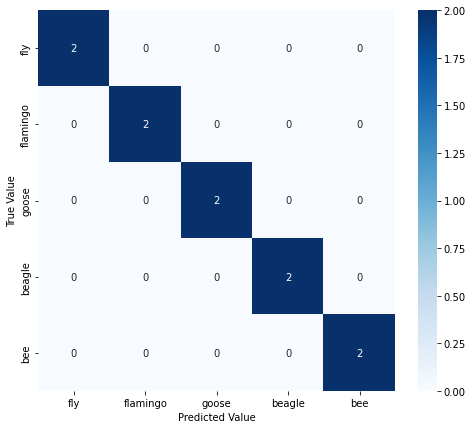

In [362]:
classes_used = ['fly', 'flamingo', 'goose', 'beagle', 'bee']
rn5cf = buildConfusionMatrix(inlabels, resnet50preds, classes_used)

In [373]:
df = getMetrics(inlabels, resnet50preds)

Overall Accuracy: 1.0, Precision: 1.0, Recall: 1.0, F1-Score: 1.0


In [390]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

For the prebuilt ResNet50 network imported from PyTorch, it uses a convolutional layer followed by a pooling layer. Then pipes the output through several layers of sequential convolution layers followed by 2D batch normalizations. There are a total of 4 layers in the middle. For this network it outputs 1000 features, corresponding to a probability of 1 of the 1000 imagenet classes.

In general ResNets can be described as sets of convolutional layers that bypass the input on a set interval of convolutions. This resolves the issue of vanishing gradients, as if an output gradient is 0 from the previous layer, the model can use the gradient several layers back to inform the new input.

## ResNet18 Model Training w/ MNIST

In [364]:
# Hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 1  # Training for 1 Epoch cause I don't feel like waiting forever

In [380]:
# Downloads the MNIST training set and test set. Uses Transforms to normalize and convert to tensors.
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST('/content/',train=True, download=True, transform = transform)
test_data = datasets.MNIST('/content/',train=False, download=True, transform = transform)
print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


In [381]:
# Converts tensors into iterable batches that will be fed sequentially to the network
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [367]:
print(len(test_dataloader.dataset))
print(len(test_dataloader))

10000
157


In [382]:
# Uses prebuilt resnet18 model from Pytorch, but modifies the first convolutional layer to handle single-channel (gray-scale) images.
resnet18 = models.resnet18()
resnet18.conv1 = torch.nn.Conv2d(1, batch_size, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [385]:
# Sets the model, loss function, and optimizer to use when training.
model = resnet18
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [384]:
# Trains the model (Takes time using the CPU)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 6.905941  [    0/60000]
loss: 2.044286  [ 6400/60000]
loss: 0.838306  [12800/60000]
loss: 0.580539  [19200/60000]
loss: 0.391294  [25600/60000]
loss: 0.329491  [32000/60000]
loss: 0.199647  [38400/60000]
loss: 0.320960  [44800/60000]
loss: 0.262924  [51200/60000]
loss: 0.323968  [57600/60000]
Done!


## MNIST Testing

In [386]:
resnet18preds, truelabels = test(test_dataloader,resnet18,loss_fn)

Test Error: 
 Accuracy: 94.2%, Avg loss: 0.201662 



In [ ]:
# Simply outputs predictions and original values
#print(resnet18preds)
#print(truelabels)

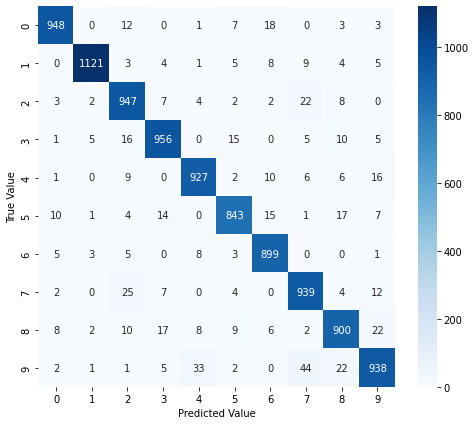

In [387]:
buildConfusionMatrix(truelabels, resnet18preds, [0,1,2,3,4,5,6,7,8,9])

In [388]:
getMetrics(truelabels, resnet18preds)

Overall Accuracy: 0.9418, Precision: 0.9417402507507784, Recall: 0.9414392841047377, F1-Score: 0.9414516903050812


(0.9418, 0.9417402507507784, 0.9414392841047377, 0.9414516903050812)

The MNIST datasets were obtained by using the Datasets and Dataloaders library functions to download both the 60,000 image training set, and 10,000 image test set. These images were then normalized to reduce the range of values in each tensor. There was no need to resize the images, as all of the images in MNIST are 28x28.

Because the prebuilt resnet18 model from Pytorch only works with 3-channel images, I modified the first convolutional layer to handle single-channel (gray-scale) images.

Then I trained the custom ResNet18 network with the 60,000 training images, and let it use a Gradient Descent optimizer and Cross Entropy loss function.

After testing the model on the 10,000 image test set, I was able to plot the confusion matrix and metrics using the respective `buildConfusionMatrix` and `getMetrics` functions above.

The test set caused some inaccuracies, but the F1-score and Accuracy are both near 1.